In [1]:
%load_ext autoreload
%autoreload 2
import gc

from tqdm import tqdm

import pathlib

import torch
import numpy as np
import soundfile as sf

from rt_vocaltract import datasets
from rt_vocaltract import models
from rt_vocaltract.utils import Configs

import IPython

from scipy.stats import pearsonr
import matplotlib.pyplot as plt

from wav2avatar.inversion import linear_inversion
from wav2avatar.utils import Utils

/home/prabhune/miniconda3/envs/w2a/lib/python3.10/site-packages/s3prl/upstream/byol_s/byol_a/common.py:20: UserWarning: torchaudio._backend.set_audio_backend has been deprecated. With dispatcher enabled, this function is no-op. You can remove the function call.
  torchaudio.set_audio_backend("sox_io")
ESPnet is not installed, cannot use espnet_hubert upstream
/home/prabhune/miniconda3/envs/w2a/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# LibriTTS Pseudolabeled Data Exploration

EMA is in MNGU0 format, then pitch, periodicity, then wavlm_cnn

In [2]:
device = 0

In [5]:
libri_root = pathlib.Path("/data/common/LibriTTS_R/")

wav_root = libri_root / "wavs"
feat_root = libri_root / "features"

In [6]:
first_wav = next(wav_root.glob("*.wav"))
first_feat_dict = np.load(feat_root / first_wav.with_suffix(".npy").name, allow_pickle=True).item()
first_feat_ema = first_feat_dict["ema"]
first_feat_wlm = first_feat_dict["wavlm_cnn"]
IPython.display.Audio(first_wav)

In [7]:
first_feat_dict.keys()

dict_keys(['ema', 'pitch', 'loudness', 'periodicity', 'wavlm_cnn'])

## Using our Dataset, try to make SoundStream skeleton

In [8]:
data_path = "/data/common/LibriTTS_R"
lttsr = datasets.LibriTTSRDataset(data_path)

--- loading LibriTTS_R dataset ---
-- wav root: /data/common/LibriTTS_R/wavs ---
-- feature root: /data/common/LibriTTS_R/features ---
--- loaded LibriTTS_R dataset ---


In [ ]:
wav, feat = lttsr[4]
print(wav.shape, feat.shape)
wav = wav.unsqueeze(0)

torch.Size([1, 1052164]) torch.Size([2191, 14])


In [ ]:
conv1 = torch.nn.Conv1d(in_channels=1, out_channels=512, kernel_size=7, stride=1, padding=0)

x = conv1(wav)
print(x.shape)

torch.Size([1, 512, 1052158])


In [ ]:
class ResidualUnit(torch.nn.Module):
    def __init__(self,
                 in_channels,
                 out_channels,
                 kernel_size,
                 stride,
                 dilation):
        super(ResidualUnit, self).__init__()
        self.dilated_conv = torch.nn.Conv1d(
            in_channels=in_channels, 
            out_channels=out_channels, 
            kernel_size=kernel_size, 
            stride=stride,
            dilation=dilation)
        self.single_conv = torch.nn.Conv1d(
            in_channels=in_channels, 
            out_channels=out_channels, 
            kernel_size=1, 
            stride=stride)
    
    def forward(self, x):
        conv_x = self.dilated_conv(x)
        conv_x = self.single_conv(conv_x)
        x = x[:, :, :conv_x.shape[2]]
        return x + conv_x

class EncoderBlock(torch.nn.Module):
    def __init__(self, 
                 in_channels, 
                 out_channels, 
                 stride, 
                 dilations,
                 kernel_size):
        super(EncoderBlock, self).__init__()
        self.res_units = torch.nn.ModuleList([
            ResidualUnit(
                in_channels=in_channels, 
                out_channels=out_channels // 2, 
                kernel_size=kernel_size, 
                stride=1, 
                dilation=dilation
                )
            for dilation in dilations
        ])
        self.conv = torch.nn.Conv1d(in_channels, out_channels, kernel_size=2 * stride, stride=stride)
    
    def forward(self, x):
        for res_unit in self.res_units:
            x = res_unit(x)
        x = self.conv(x)
        return x

In [ ]:
res_unit1 = ResidualUnit(in_channels=512,
                         out_channels=512,
                         kernel_size=7,
                         stride=1,
                         dilation=1).to(device)
res_unit2 = ResidualUnit(in_channels=512,
                         out_channels=512,
                         kernel_size=7,
                         stride=1,
                         dilation=3).to(device)
res_unit3 = ResidualUnit(in_channels=512,
                         out_channels=512,
                         kernel_size=7,
                         stride=1,
                         dilation=9).to(device)
conv2 = torch.nn.Conv1d(in_channels=512,
                        out_channels=512,
                        kernel_size=4,
                        stride=2).to(device)
x = conv1(wav).to(0)
x = res_unit1(x)
x = res_unit2(x)
x = res_unit3(x)
x = conv2(x)
print(x.shape)

torch.Size([1, 512, 526039])


In [ ]:
C = 14
with torch.no_grad():
    conv1 = torch.nn.Conv1d(in_channels=1, out_channels=C, kernel_size=7, stride=1, padding=0)
    enc1 = EncoderBlock(in_channels=C, out_channels=C * 2, stride=2, kernel_size=7, dilations=[1, 3, 9]).to(device)
    enc2 = EncoderBlock(in_channels=C * 2, out_channels=C * 4, stride=5, kernel_size=7, dilations=[1, 3, 9]).to(device)
    enc3 = EncoderBlock(in_channels=C * 4, out_channels=C * 8, stride=6, kernel_size=7, dilations=[1, 3, 9]).to(device)
    enc4 = EncoderBlock(in_channels=C * 8, out_channels=C * 16, stride=8, kernel_size=7, dilations=[1, 3, 9]).to(device)
    conv_end = torch.nn.Conv1d(in_channels=C * 16, out_channels=C, kernel_size=3, stride=1).to(device)

    wav = torch.zeros(1, 1, 1052164)
    x = conv1(wav).to(device)
    print(x.shape)
    x = enc1(x)
    print(x.shape)
    x = enc2(x)
    print(x.shape)
    x = enc3(x)
    print(x.shape)
    x = enc4(x)
    print(x.shape)
    x = conv_end(x)

    print(x.shape)

torch.Size([1, 14, 1052158])
torch.Size([1, 28, 526039])
torch.Size([1, 56, 105191])
torch.Size([1, 112, 17517])
torch.Size([1, 224, 2178])
torch.Size([1, 14, 2176])


## SoundStream Model Dimension Sanity Check

In [ ]:
inv_model = models.SoundStreamInversion(in_channels=1, out_channels=14, kernel_size=7, strides=[2, 5, 6, 8], dilations=[1, 3, 9]).to(device)

In [ ]:
dataloader = torch.utils.data.DataLoader(lttsr, batch_size=8, shuffle=True)

In [ ]:
wav, feat = next(iter(dataloader))

inv_model(wav.to(device)).shape

torch.Size([8, 14, 2176])

In [ ]:
disc = models.MelGANMultiScaleDiscriminator(
    in_channels=14,
    out_channels=1
)

In [9]:
root = pathlib.Path("/data/prabhune/rt_vocaltract/ckpts/")
config = Configs.load_config(root / "def" / "ssinv_def.yaml")
ckpt = root / "def" / "ssinv_l1_0.22.pth"

In [18]:
train_data, val_data, test_data = Configs.load_dataset(config)

--- loading LibriTTS_R dataset ---
-- wav root: /data/common/LibriTTS_R/wavs ---
-- feature root: /data/common/LibriTTS_R/features ---
--- loaded LibriTTS_R dataset ---
373339


In [10]:
model = Configs.load_model(config, ckpt)

In [48]:
wav, feat = val_data[1012]

In [49]:
IPython.display.Audio(wav, rate=24000)

In [50]:
feat_hat = model(wav.unsqueeze(0))
feat_hat = feat_hat.transpose(2, 1)
feat_hat = datasets.LibriTTSRDataset.pad_feat(feat_hat)

In [51]:
feat_hat = feat_hat.squeeze(0).detach().numpy()
feat = feat.detach().numpy()

In [52]:
feat_hat = linear_inversion.EMADataset.butter_bandpass_filter(feat_hat, 10, 50)
feat = linear_inversion.EMADataset.butter_bandpass_filter(feat, 10, 50)

0.8124724544346266


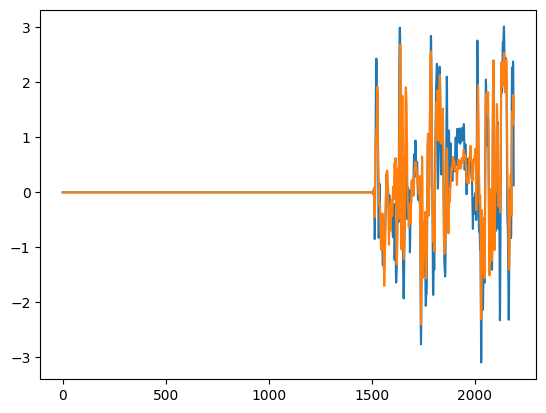

In [53]:
feat_num = 0
plt.plot(feat[:, feat_num])
plt.plot(feat_hat[:, feat_num])
corrs = np.array([pearsonr(feat[:, i], feat_hat[:, i])[0] for i in range(feat.shape[1])]).mean()
print(corrs)

In [19]:
corrs = []
for i, (wav, feat) in tqdm(enumerate(val_data)):
    feat_hat = model(wav.unsqueeze(0))
    feat_hat = feat_hat.transpose(2, 1)
    feat_hat = datasets.LibriTTSRDataset.pad_feat(feat_hat)
    feat_hat = feat_hat.squeeze(0).detach().numpy()
    feat = feat.detach().numpy()
    feat_hat = linear_inversion.EMADataset.butter_bandpass_filter(feat_hat, 10, 50)
    feat = linear_inversion.EMADataset.butter_bandpass_filter(feat, 10, 50)
    corr = np.array([pearsonr(feat[:, i], feat_hat[:, i])[0] for i in range(feat.shape[1])]).mean()
    corrs.append(corr)

    if i == 10:
        break

corrs = np.array(corrs)
print(corrs.mean(), corrs.std())

10it [00:21,  2.16s/it]

0.8769385586859165 0.029549321574170145


In [67]:
def plot_ema_dims(feat, feat_hat):
    fig, axs = plt.subplots(7, 2, figsize=(10, 20))

    for i, ax in enumerate(axs):
        ax[0].plot(feat[1500:2000, i], label="gt")
        ax[0].plot(feat_hat[1500:2000, i], label="pred")
        ax[0].set_title(f"EMA dim {i}")
        ax[0].axis('off')

        ax[1].plot(feat[1500:2000, i + 7], label="gt")
        ax[1].plot(feat_hat[1500:2000, i + 7], label="pred")
        ax[1].set_title(f"EMA dim {i + 7}")
        ax[1].axis('off')
    axs[0][0].legend()

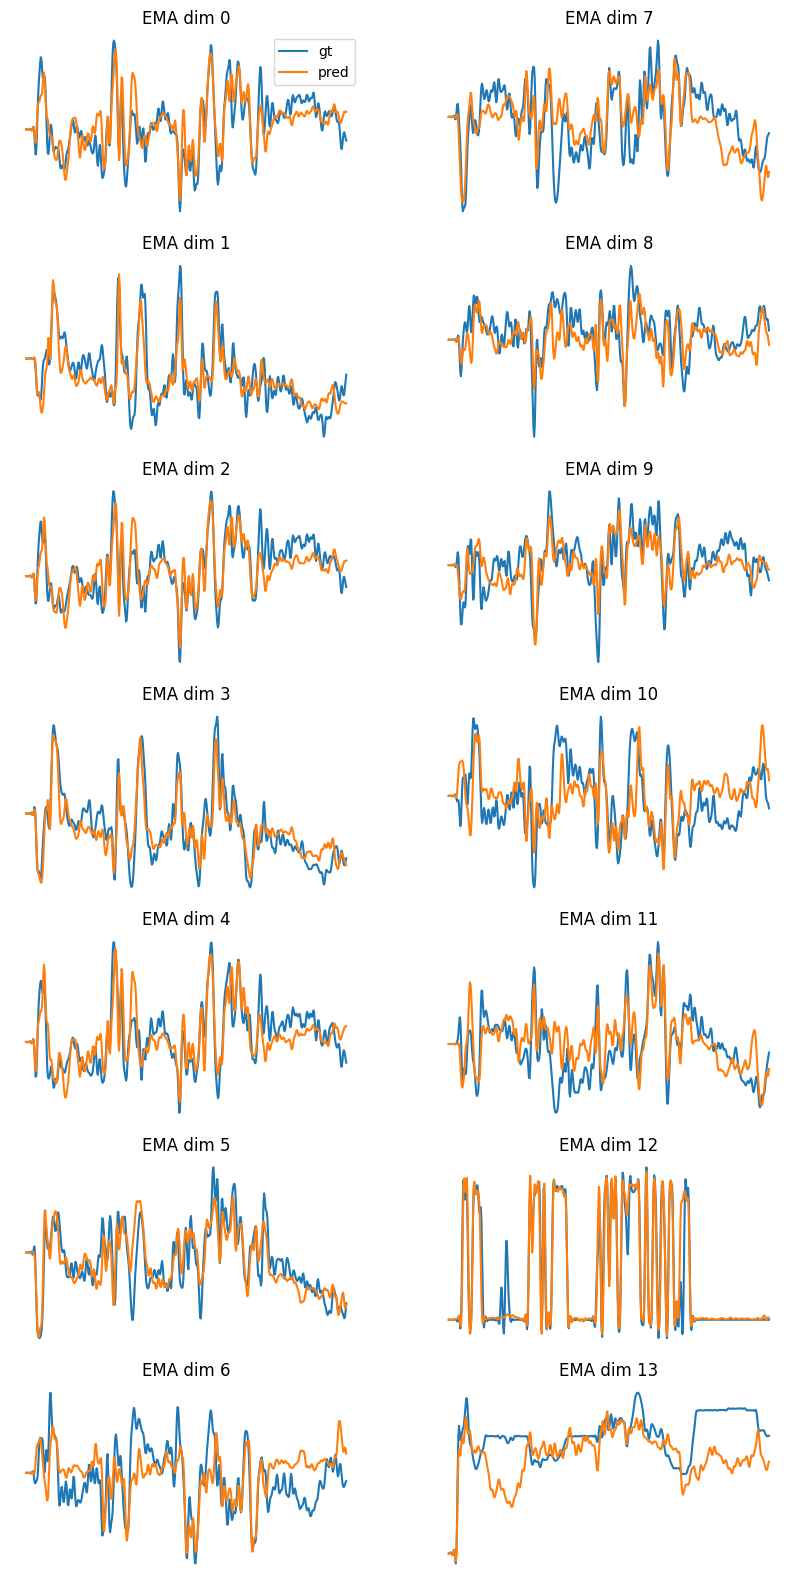

In [68]:
plot_ema_dims(feat, feat_hat)

In [65]:
feat_hat_hprc = Utils.mngu0_to_hprc(feat_hat)

In [66]:
np.save("ema/lbtts1001_hprc.npy", feat_hat_hprc[1200:, :])

In [67]:
sf.write("ema/lbtts1001.wav", wav.squeeze().detach().cpu().numpy()[24000*(1200 // 50):], 24000)

In [58]:
np.save("ema/lbtts0_mng.npy", feat_hat[300:])